## LSTM Auto-Encoder-Decoder for Anomaly Detection: 
Based on Philip Jeremy's work from (https://gist.github.com/philipperemy/b8a7b7be344e447e7ee6625fe2fdd765)

## Detect anomalous points on time series data of cpu utilization

In [160]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
np.random.seed(23)

### Read Data for Cpu utilization, we want to reconstruct the time series using LSTM based Auto-Encoder

In [162]:
df = pd.read_csv('df_merged.csv', parse_dates=['days'], index_col='days')

In [163]:
df.sample(5)

,dt,cur_time_in_gmt,cpu_utilization_pctg,hour,cpu_utilization_pctg_extrapolated,is_extrapolated
days,,,,,,
2017-07-21 01:00:00,7/20/2017,7/21/2017 1:00,50.833,1,50.833,False
2017-04-06 21:00:00,4/6/2017,4/6/2017 21:00,48.611,21,48.611,False
2017-05-12 21:00:00,5/12/2017,5/12/2017 21:00,58.889,21,58.889,False
2017-04-17 07:00:00,4/17/2017,4/17/2017 7:00,26.382,7,26.382,False
2017-04-04 07:00:00,4/4/2017,4/4/2017 7:00,34.167,7,34.167,False


**We collect cpu usage data per hour eveyday, so there are 24 readings per day**

In [164]:
df = df[['cpu_utilization_pctg_extrapolated']]
df.columns = ['cpu_util_pctg']
df.sample(5)

,cpu_util_pctg
days,
2017-04-15 03:00:00,61.066
2017-06-10 20:00:00,46.125
2017-07-06 03:00:00,55.833
2017-05-26 08:00:00,31.389
2017-05-02 23:00:00,33.629


In [165]:
#from sklearn.preprocessing import StandardScaler

# Normalize the  data (center around 0 and scale to remove the variance).
#scaler = StandardScaler()
#df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

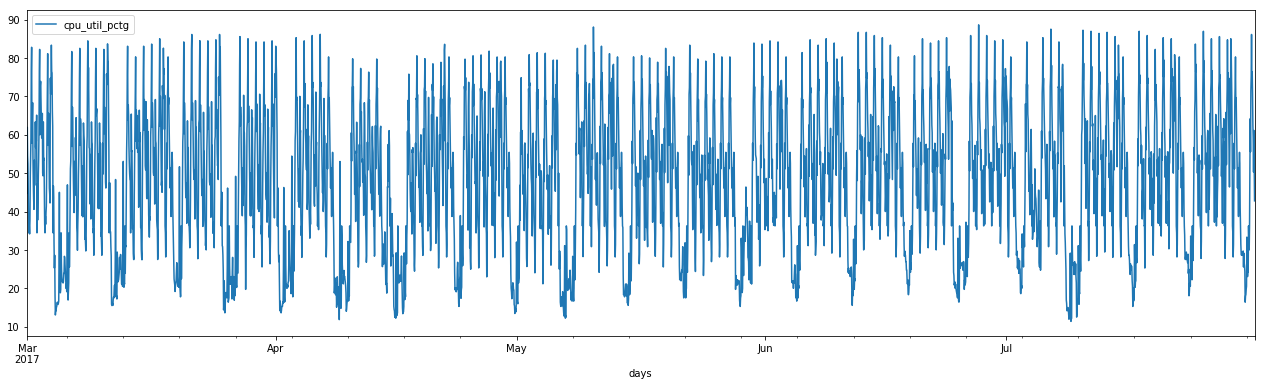

In [166]:
df.plot(figsize=(22,6));

In [167]:
len(df)

3672

### Create the training, validation and test sets

In [168]:
signal_train = df['2017-03-01':'2017-05-31'].values # March to May
signal_valid = df['2017-06-01':'2017-06-30'].values # June
signal_test = df['2017-07-01':'2017-07-31'].values # July

**Prepare Training Sequences: Create windows of 48 data points each**

In [169]:
window_length = 48 # Why 48? 24 readings in a day, so took for 2 days

In [170]:
train_windows = []

In [171]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [172]:
len(train_windows)

2161

In [173]:
len(signal_test)

744

In [174]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [175]:
x_train = np.array(train_windows)
x_train.shape

(2161, 48, 1)

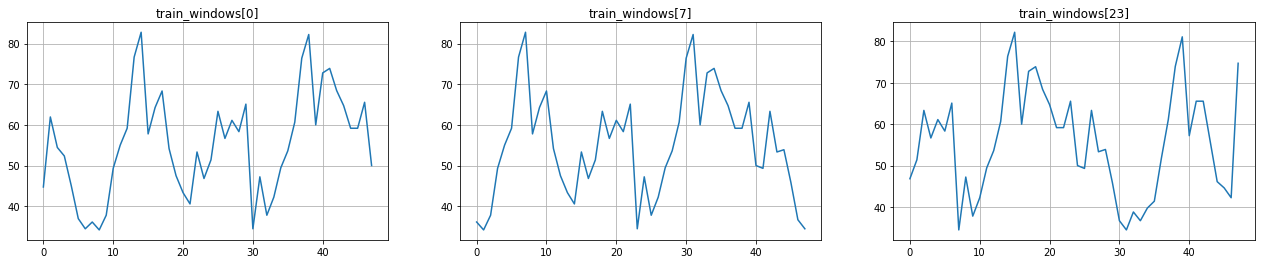

In [176]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

**Prepare Validation Sequences: Create windows of 48 data points each**

In [177]:
valid_windows = []

In [178]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [179]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [180]:
x_valid = np.array(valid_windows)
x_valid.shape

(673, 48, 1)

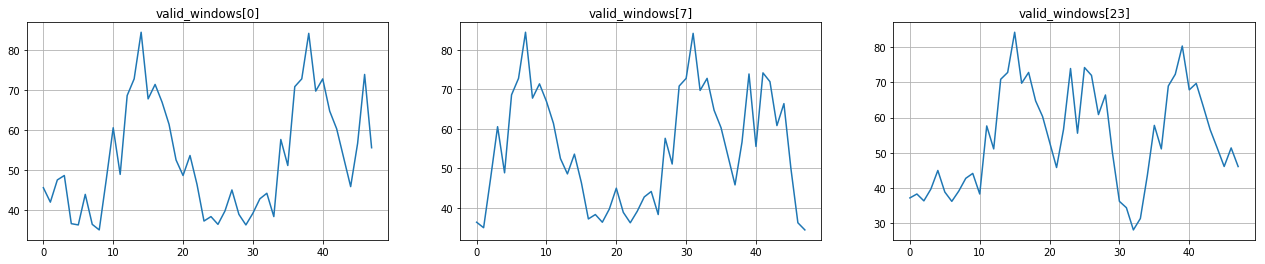

In [181]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

### Create the LSTM Auto-Encoder Model

In [182]:
hidden_dim = 24
batch_size = 168 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 50
select_only_last_state = False

In [183]:
# Based on Philip Jeremy's implementation
m = Sequential()
if select_only_last_state:
    m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
    m.add(RepeatVector(window_length))
else:
    m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m.add(Dropout(rate=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))
m.compile(loss='mse', optimizer='adam')

In [184]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48, 24)            2496      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 24)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 1)             104       
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
_________________________________________________________________


In [185]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid), shuffle=False).history

Train on 2161 samples, validate on 673 samples
Epoch 1/50
2161/2161 [==============================] - 4s - loss: 2536.4556 - val_loss: 2779.0782
Epoch 2/50
2161/2161 [==============================] - 2s - loss: 2497.2877 - val_loss: 2769.7003
Epoch 3/50
2161/2161 [==============================] - 2s - loss: 2490.8113 - val_loss: 2764.9497
Epoch 4/50
2161/2161 [==============================] - 2s - loss: 2477.7111 - val_loss: 2733.1633
Epoch 5/50
2161/2161 [==============================] - 2s - loss: 2452.8400 - val_loss: 2720.5468
Epoch 6/50
2161/2161 [==============================] - 2s - loss: 2443.8900 - val_loss: 2713.4916
Epoch 7/50
2161/2161 [==============================] - 2s - loss: 2437.4565 - val_loss: 2706.6532
Epoch 8/50
2161/2161 [==============================] - 2s - loss: 2424.4407 - val_loss: 2682.3357
Epoch 9/50
2161/2161 [==============================] - 2s - loss: 2392.2109 - val_loss: 2637.5613
Epoch 10/50
2161/2161 [==============================] - 2s - 

In [186]:
pred_x_valid = m.predict(x_valid)

### Visualize the reconstruction on the validation set (select random sets)

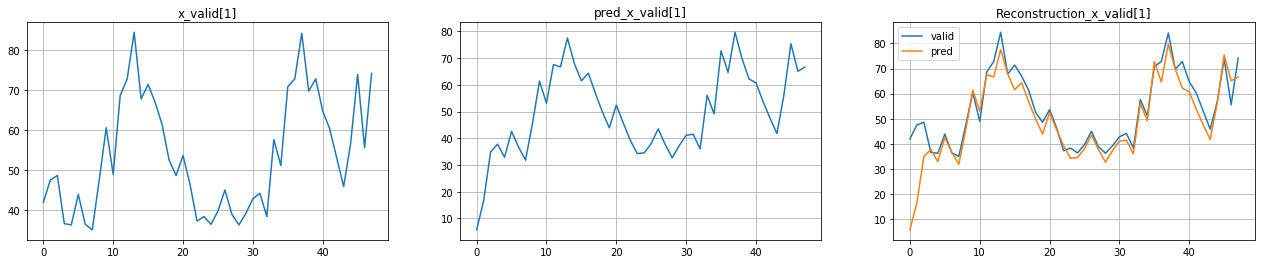

In [187]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[1])
plt.title('x_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[1])
plt.title('pred_x_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[1], label='valid')
plt.plot(pred_x_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[1]')
plt.grid(True)
plt.show();

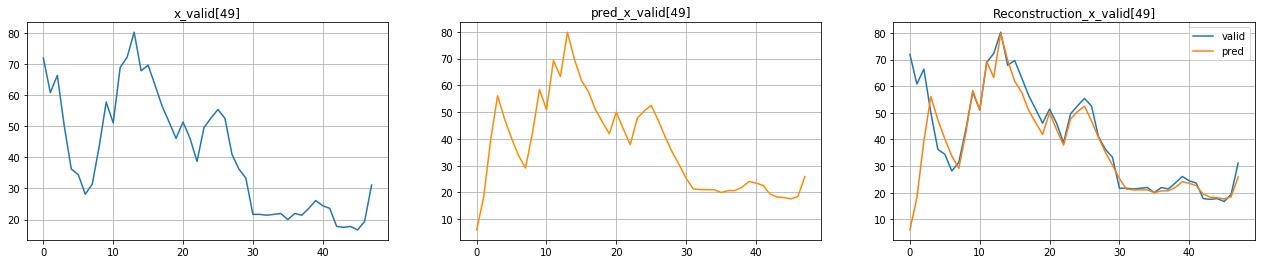

In [188]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[49])
plt.title('x_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[49], label='valid')
plt.plot(pred_x_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[49]')
plt.grid(True)
plt.show();

### Summarise Model Loss Over Training Epochs

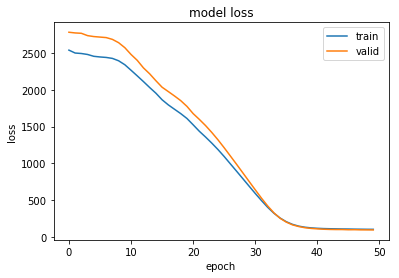

In [189]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [190]:
signal_test[201]

array([ 26.667])

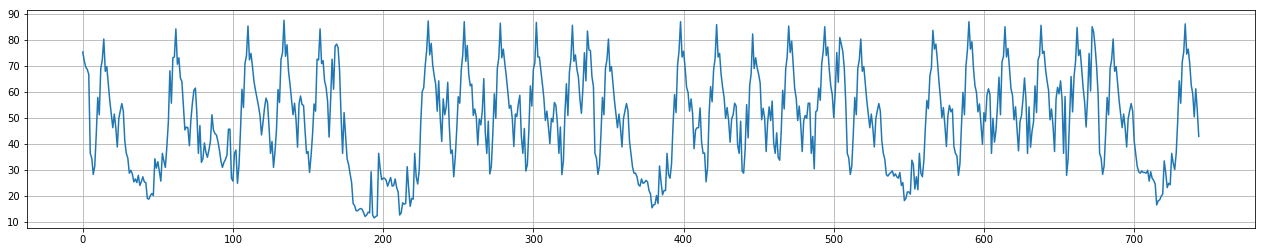

In [191]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.grid(True)

### Simulate Anomalies on the test set (select random points)

In [192]:
simulated_signal_test = np.copy(signal_test)

In [193]:
random_indices = [201, 422] # random points chosen
simulated_signal_test[201] = 80
simulated_signal_test[422] = 35

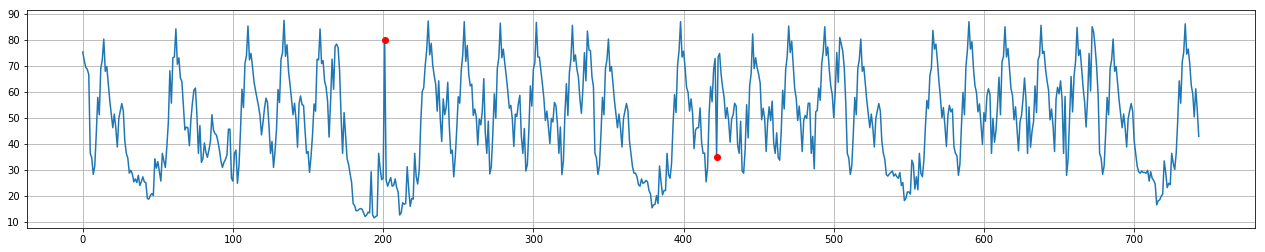

In [194]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
plt.grid(True)

**Prepare Test Sequences: Create windows of 48 data points each**

In [195]:
test_windows = []
contain_outliers= []

In [196]:
for window_start in range(0, len(simulated_signal_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(simulated_signal_test[window_range])
    is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    contain_outliers.append(is_outlier)
    test_windows.append(window)

In [197]:
x_test = np.array(test_windows)
x_test.shape

(697, 48, 1)

In [198]:
pred_x_test = m.predict(x_test)

### Visualize the reconstruction on the simulated test set (select random sets)

In [199]:
outlier_indices = np.where(contain_outliers)[0]

In [200]:
outlier_indices

array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 375, 376, 377, 378,
       379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
       418, 419, 420, 421, 422])

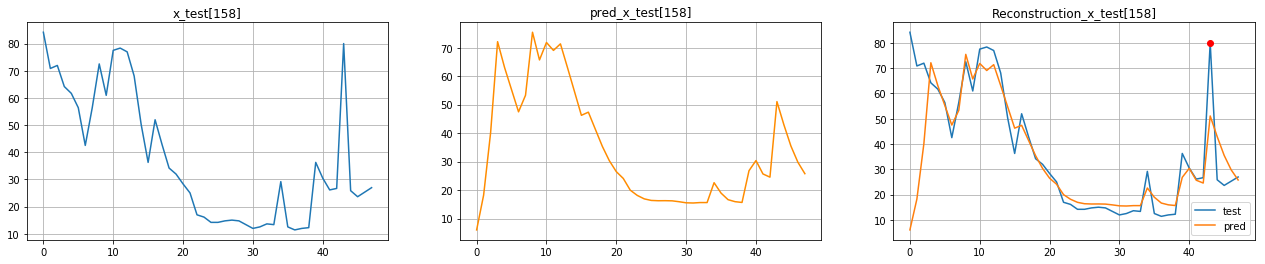

In [201]:
# Visualize the reconstruction on test sequence[201]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[158])
plt.title('x_test[158]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[158], color='darkorange')
plt.title('pred_x_test[158]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[158], label='test')
plt.plot(pred_x_test[158], label='pred')
plt.plot(201 - 158, x_test[158][201-158], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[158]')
plt.grid(True)
plt.show();

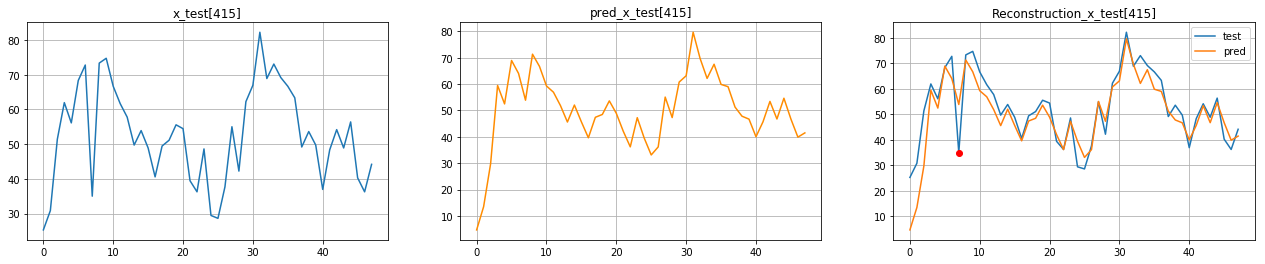

In [202]:
# Visualize the reconstruction on test sequence[422]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[415])
plt.title('x_test[415]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[415], color='darkorange')
plt.title('pred_x_test[415]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[415], label='test')
plt.plot(pred_x_test[415], label='pred')
plt.plot(422 - 415, x_test[415][422-415], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[415]')
plt.grid(True)
plt.show();

In [204]:
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_of_predictions

array([ 4797.12143164,  4346.63569935,  4023.43453383,  3918.52249737,
        3679.08876907,   944.0384826 ,   841.24573228,   537.79873965,
         790.55038038,  1625.4616837 ,  2685.11702968,  2599.69690065,
        3958.6605618 ,  4388.51117985,  5512.33410738,  3823.52186648,
        4051.75595483,  3270.54473011,  2558.57031045,  2070.97762618,
        1625.87368422,  2070.97762618,  1624.76323552,  1094.46031894,
        1911.98606398,  2184.81194931,  2448.7693149 ,  2178.07973991,
        1250.05608942,   944.0384826 ,   841.24573228,   557.40530941,
         606.65912042,   545.40997989,   423.8371743 ,   465.42346235,
         413.83727775,   521.85408675,   375.05208616,   423.8371743 ,
         498.80282704,   423.8371743 ,   413.83727775,   227.60713638,
         220.5784603 ,   256.7765814 ,   278.32236388,   459.39755892,
         826.04493715,   645.01592072,   767.84823816,   581.79128736,
         491.92550793,   944.0384826 ,   782.13899674,   658.01794869,
      

In [205]:
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
mae_threshold

3909.9885543172586

In [206]:
pred_outlier_indices = np.where(mae_of_predictions > mae_threshold)[0]
pred_outlier_indices

array([  0,   1,   2,   3,  12,  13,  14,  16,  60,  61,  62,  63,  64,
       108, 109, 110, 111, 112, 113, 132, 133, 134, 135, 136, 156, 157,
       158, 159, 160, 166, 168, 169, 170, 200, 201, 228, 229, 230, 231,
       232, 233, 253, 254, 255, 256, 276, 277, 278, 279, 280, 281, 300,
       301, 302, 303, 304, 325, 326, 327, 328, 329, 334, 335, 336, 337,
       338, 348, 349, 350, 352, 396, 397, 398, 399, 400, 401, 421, 423,
       424, 445, 446, 447, 448, 449, 468, 469, 470, 471, 472, 473, 492,
       493, 494, 495, 496, 497, 502, 503, 504, 505, 506, 507, 516, 517,
       518, 520, 565, 566, 567, 568, 569, 588, 589, 590, 591, 592, 593,
       612, 613, 614, 615, 616, 617, 636, 637, 638, 639, 640, 641, 661,
       662, 663, 664, 665, 670, 671, 672, 673, 674, 675, 684, 685, 686, 688])

In [207]:
len(pred_outlier_indices)

144

In [208]:
len(outlier_indices)

96